In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# relu函数
x = torch.arange(-8, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)

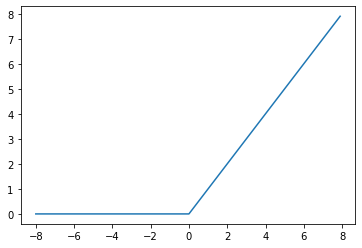

In [3]:
plt.plot(x.detach().numpy(), y.detach().numpy())

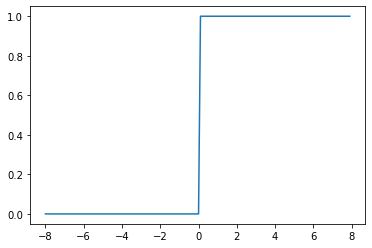

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
plt.plot(x.detach().numpy(), x.grad)

# 从零实现

In [5]:
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [6]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, 
                             requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, 
                             requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [7]:
# 激活函数
def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)

In [8]:
# 模型
def net(x):
    x = x.reshape((-1, num_inputs))
    H = relu(x@W1+b1)  # @为矩阵乘法
    return (H@W2+b2)

In [9]:
# 损失函数
loss = nn.CrossEntropyLoss()

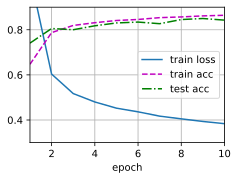

In [10]:
num_epochs, lr = 10, 0.1
optimizer = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

# 简洁实现

In [11]:
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [12]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

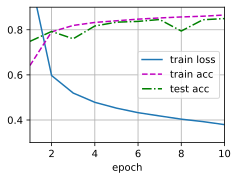

In [13]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 欠拟合和过拟合

In [20]:
import math
import numpy as np
# 多项式拟合，生成数据
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [21]:
# numpy转为tensor
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

In [22]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    
    return metric[0] / metric[1]

In [24]:
def train(train_features, test_features, train_labels, test_labels, 
         num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                               batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                              batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                           xlim=[1, num_epochs], ylim=[1e-3, 1e2], 
                           legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), 
                                  evaluate_loss(net, test_iter, loss)))
    print("weight:", net[0].weight.data.numpy())

weight: [[ 5.0044074  1.2002127 -3.404221   5.604046 ]]


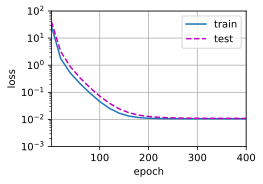

In [25]:
# 选择拟合4个维度，0-3阶
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
     labels[:n_train], labels[n_train:])

weight: [[3.2063441 3.6791103]]


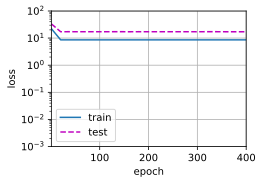

In [26]:
# 只选择2个维度，欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2], 
     labels[:n_train], labels[n_train:])

weight: [[ 4.92900276e+00  1.30596888e+00 -3.11078358e+00  5.01832962e+00
  -6.20115340e-01  1.66450655e+00 -8.36138725e-02  6.96489811e-02
   1.67758688e-01 -1.55008495e-01 -1.44794241e-01 -1.23253306e-02
  -1.12846367e-01 -1.79044724e-01  1.57737747e-01  1.11740984e-01
  -2.03868315e-01  2.16801405e-01 -2.56079668e-03 -1.95098490e-01]]


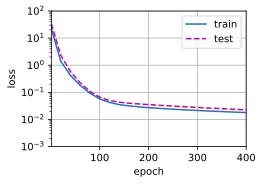

In [27]:
# 选择20阶，过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :], 
     labels[:n_train], labels[n_train:])

# Dropout

In [29]:
def dropout_layer(X, dropout):
    # 注意此处是Inverted Dropout并不是vanilla版本，直接在X上进行缩放倍数
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(x) # 丢弃所有元素
    if dropout == 0:
        return X
    
    mask = (torch.Tensor(X.shape).uniform_(0, 1) > dropout).float()
    return mask * X / (1.0 - dropout)

In [31]:
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5

In [32]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2,
                is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.l1 = nn.Linear(num_inputs, num_hidden1)
        self.l2 = nn.Linear(num_hidden1, num_hidden2)
        self.l3 = nn.Linear(num_hidden2, num_outputs)
        
        self.relu = nn.ReLU()
        
    def forward(self, X):
        h1 = self.relu(self.l1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            h1 = dropout_layer(h1, dropout1)
        
        h2 = self.relu(self.l2(h1))
        
        if self.training == True:
            h1 = dropout_layer(h2, dropout2)
        
        out = self.l3(h2)
        return out

In [33]:
net = Net(num_inputs, num_outputs, num_hidden1, num_hidden2)

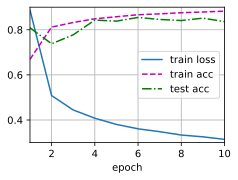

In [34]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

In [36]:
net = nn.Sequential(nn.Flatten(), 
                   nn.Linear(784, 256), 
                   nn.ReLU(),
                   nn.Dropout(dropout1),
                   nn.Linear(256, 256), 
                   nn.ReLU(),
                   nn.Dropout(dropout2),
                   nn.Linear(256, 10))
def init_weight2(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

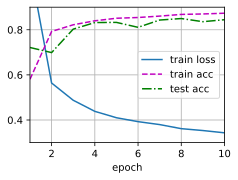

In [37]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)